In [28]:
%load_ext autoreload
%autoreload 2

import sys
import os
import random
import pickle
from pathlib import Path
import logging

import numpy as np
import pandas as pd # Although not heavily used, good practice
import matplotlib.pyplot as plt # For basic plot handling if needed

# Nilearn imports
import nilearn.datasets
import nilearn.image
import nilearn.plotting as nplotting # Use alias
from nilearn.maskers import NiftiMasker

# --- Add src to sys.path ---
BASE_DIR = Path.cwd().parent
SRC_DIR = BASE_DIR / 'src'

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
    print(f"Added {SRC_DIR} to sys.path")
if str(BASE_DIR) not in sys.path:
     sys.path.insert(0, str(BASE_DIR))
     print(f"Added {BASE_DIR} to sys.path")

# --- Import project modules ---
from plotting_utils import get_network_rgba # Reused from utils.py
from atlas_utils import prepare_roi_images, load_schaefer_atlas
from neurosynth_utils import plot_roi_neurosynth_overlap, calculate_roi_neurosynth_overlap
from file_utils import load_pickle

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Set Seeds (Less critical here, but good practice) ---
SEED = 789 # Choose a seed
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using random seed: {SEED}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using random seed: 789


### CONFIGURATION

In [24]:
# --- Core Project Structure ---
# (BASE_DIR should be defined in the previous cell)
DATA_DIR = BASE_DIR / "data"
REPORTS_DIR = BASE_DIR / "reports"
FIGURE_DIR = REPORTS_DIR / "figures"
ANALYSIS_RESULTS_DIR = REPORTS_DIR / "analysis_results" # Ensure this is defined
DEGREE_CENTRALITY_DIR = ANALYSIS_RESULTS_DIR / "degree_centrality" / "threeclass" # Path to saved DC results

# --- Input Data Locations ---
# Location where downloaded atlases are stored (or will be stored by nilearn)
NILEARN_DATA_DIR = DATA_DIR / "nilearn_data"
NILEARN_DATA_DIR.mkdir(parents=True, exist_ok=True)

# --- DC Results File ---
# Path to the saved pickle file containing the nested DC dictionary
# Saved as "{group_key: {model_key: {parcel_name: mean_dc}}}" by Notebook 2
DC_SUMMARY_PICKLE_PATH = DEGREE_CENTRALITY_DIR / "threeclass_dc_summary.pkl" # From Notebook 2 Cell #14

# Directory containing Neurosynth statistical maps (.nii.gz files)
# IMPORTANT: Update this path to where your maps actually are!
NEUROSYNTH_MAP_DIR = DATA_DIR / "neurosynth_maps"
# NEUROSYNTH_MAP_DIR = BASE_DIR / "analysis" / "neurosynth" # If using original path structure

# Define Neurosynth maps to analyze (Map Name -> Filename relative to NEUROSYNTH_MAP_DIR)
# IMPORTANT: Update filenames to match yours
NEUROSYNTH_MAPS = {
    "craving": "craving_uniformity-test_z_FDR_0.01.nii.gz",
    "drug": "drug_uniformity-test_z_FDR_0.01.nii.gz",
    "alcohol": "alcohol_uniformity-test_z_FDR_0.01.nii.gz",
}

# --- Atlas Parameters ---
N_ROIS = 100
YEO_NETWORKS = 7
RESOLUTION_MM = 2
ATLAS_NAME = "Schaefer2018" # For descriptive purposes

# --- Dynamic ROI Selection Parameters ---
# Define which model's DC results to use for selecting ROIs for each group
# The key should match a model key present in the DC_SUMMARY_PICKLE_PATH file
# Using OVR_L2_logistic for all as an example:
ROI_SELECTION_MODEL_KEY = {
    'HC': 'OVR_L2_logistic_HC', # Or just 'OVR_L2_logistic' if that key exists with HC data
    'Cannabis': 'OVR_L2_logistic_Cannabis',
    'Alcohol': 'OVR_L2_logistic_Alcohol'
}
# Define how many top ROIs (by DC) to select for each group
N_TOP_ROIS_TO_SELECT = 20 # Select top 20 ROIs (adjust as needed)

# --- Output Locations ---
NEUROSYNTH_FIGURE_DIR = FIGURE_DIR / "neurosynth_overlap"
NEUROSYNTH_FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# --- Plotting Parameters ---
CONTOUR_CMAP_NEUROSYNTH = nplotting.cm.black_red # Colormap for Neurosynth map contours
CONTOUR_CMAP_CHOSEN_ROI = nplotting.cm.black_green # Colormap for chosen ROI contours
CONTOUR_CMAP_OTHER_ROI = nplotting.cm.brown_blue # Colormap for other ROI contours
CONTOUR_LINEWIDTH = 0.5
DISPLAY_MODE = 'x' # Anatomical display mode ('x', 'y', 'z', 'ortho')
CUT_COORDS = 7 # Number of slices for axial/saggital/coronal views

# --- End Configuration ---

In [25]:
# --- Verification ---
print(f"Project Base Directory: {BASE_DIR}")
print(f"Nilearn Data Directory: {NILEARN_DATA_DIR}")
print(f"Neurosynth Map Directory: {NEUROSYNTH_MAP_DIR}")
print(f"Output Figure Directory: {NEUROSYNTH_FIGURE_DIR}")
print(f"Using Atlas: {ATLAS_NAME} ({N_ROIS} ROIs)")
print(f"Analyzing Neurosynth maps: {list(NEUROSYNTH_MAPS.keys())}")

# Check Neurosynth map directory and files
if not NEUROSYNTH_MAP_DIR.is_dir():
    logging.warning(f"Neurosynth map directory NOT FOUND: {NEUROSYNTH_MAP_DIR}")
else:
    for name, fname in NEUROSYNTH_MAPS.items():
        if not (NEUROSYNTH_MAP_DIR / fname).is_file():
             logging.warning(f"Neurosynth map file NOT FOUND: {NEUROSYNTH_MAP_DIR / fname} (for map '{name}')")

Project Base Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo
Nilearn Data Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/nilearn_data
Neurosynth Map Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/neurosynth_maps
Output Figure Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap
Using Atlas: Schaefer2018 (100 ROIs)
Analyzing Neurosynth maps: ['craving', 'drug', 'alcohol']


In [30]:
# === 2. Load Atlas and Prepare ROIs ===

print("\n" + "="*40)
print("Loading Atlas and Preparing ROI Images")
print("="*40 + "\n")

# --- Load Atlas Data ---
# Uses parameters from the Configuration cell (N_ROIS, YEO_NETWORKS, RESOLUTION_MM, NILEARN_DATA_DIR)
atlas_data, parcel_names, network_inds = load_schaefer_atlas(
    n_rois=N_ROIS,
    yeo_networks=YEO_NETWORKS,
    resolution_mm=RESOLUTION_MM,
    data_dir=NILEARN_DATA_DIR
)

if atlas_data is None or parcel_names is None or network_inds is None:
    raise RuntimeError("Failed to load atlas data. Check previous logs.")

# --- Prepare Individual ROI Images ---
# This creates a list of Nifti images, one per ROI
# Uses the atlas map image from the loaded atlas_data
roi_images = prepare_roi_images(nilearn.image.load_img(atlas_data['maps'])) # Pass the actual atlas Nifti image

if not roi_images or len(roi_images) != N_ROIS:
     logging.warning(f"Number of prepared ROI images ({len(roi_images)}) does not match expected N_ROIS ({N_ROIS}). Proceeding with caution.")
     # Consider raising error if this mismatch is critical

# --- Generate Network Colors (optional, if needed later) ---
# network_rgba_tuple, network_rgba_str_list = get_network_rgba(network_inds, N_ROIS)
# print("Generated network RGBA colors.")

print("\n" + "="*40)
print("Finished Loading Atlas and Preparing ROIs")
print("="*40 + "\n")

2025-04-21 13:39:46,046 - INFO - Fetching Schaefer atlas: 100 ROIs, 7 networks, 2mm...
2025-04-21 13:39:46,050 - INFO -   Loaded 100 parcel names.
2025-04-21 13:39:46,050 - INFO -   Generated network indices for: ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
2025-04-21 13:39:46,059 - INFO - Preparing individual ROI Nifti images...
2025-04-21 13:39:46,071 - INFO -   Found 100 unique ROI labels in atlas.



Loading Atlas and Preparing ROI Images



2025-04-21 13:39:52,260 - INFO -   Prepared 100 valid ROI images.



Finished Loading Atlas and Preparing ROIs



In [38]:
# === 3. Load DC Results and Select Top ROIs ===
# This cell loads the pre-calculated average Degree Centrality scores and selects
# the top N ROIs for each group based on the configuration settings.

print("\n" + "="*40)
print("Loading DC Results and Selecting Top ROIs")
print("="*40 + "\n")

# --- Load DC Summary Data ---
print(f"Loading DC summary from: {DC_SUMMARY_PICKLE_PATH}")
try:
    # Expected structure: {group_key: {model_key: {parcel_name: mean_dc}}}
    dc_summary_data = load_pickle(DC_SUMMARY_PICKLE_PATH)
    print(f"  Successfully loaded DC summary. Groups found: {list(dc_summary_data.keys())}")
except Exception as e:
    raise RuntimeError(f"Failed to load DC summary pickle: {e}")


# --- Select Top ROIs for Each Group ---
CHOSEN_ROIS = {} # This dictionary will replace the hardcoded one
print(f"\nSelecting top {N_TOP_ROIS_TO_SELECT} ROIs based on Mean DC:")

for group_key, model_key_full in ROI_SELECTION_MODEL_KEY.items():
    # split the model key by underscore and remove the last part and rejoin
    model_key_parts = model_key_full.split('_')
    model_key = '_'.join(model_key_parts[:-1])  # Remove the last part (e.g., 'HC', 'Cannabis', 'Alcohol')
    print(f"  Processing Group: '{group_key}' using Model: '{model_key}'")

    # Check if group and model data exist in the loaded summary
    if group_key not in dc_summary_data:
        logging.warning(f"    Group key '{group_key}' not found in loaded DC summary. Skipping ROI selection.")
        CHOSEN_ROIS[group_key] = [] # Assign empty list
        continue
    if model_key not in dc_summary_data[group_key]:
        logging.warning(f"    Model key '{model_key}' not found for group '{group_key}' in DC summary. Skipping ROI selection.")
        CHOSEN_ROIS[group_key] = [] # Assign empty list
        continue

    # Get the dictionary of {parcel: dc_score} for this group/model
    parcel_dc_scores = dc_summary_data[group_key][model_key]

    if not parcel_dc_scores:
         logging.warning(f"    No DC scores found for {group_key}/{model_key}. Skipping ROI selection.")
         CHOSEN_ROIS[group_key] = []
         continue

    # Convert to Pandas Series for easy sorting
    dc_series = pd.Series(parcel_dc_scores)

    # Sort by DC descending, handle NaNs by putting them last
    sorted_dc = dc_series.sort_values(ascending=False, na_position='last')

    # Select top N ROI names
    top_n_rois = sorted_dc.head(N_TOP_ROIS_TO_SELECT).index.tolist()

    # Validate selected ROI names against the loaded parcel_names
    valid_rois = [roi for roi in top_n_rois if roi in parcel_names]
    if len(valid_rois) != len(top_n_rois):
        logging.warning(f"    Some selected ROIs for {group_key}/{model_key} were not found in the main parcel_names list.")

    CHOSEN_ROIS[group_key] = valid_rois # Store the validated list
    print(f"    Selected {len(valid_rois)} ROIs for group '{group_key}'.")
    # Optional: Print the selected ROIs
    # print(f"      ROIs: {valid_rois}")


# --- Verification ---
print("\nFinal Selected ROIs per group:")
for group, rois in CHOSEN_ROIS.items():
    print(f"  {group}: {len(rois)} ROIs")
    if not rois:
        logging.warning(f"    No ROIs were selected for group '{group}'. Check DC data and model keys.")


print("\n" + "="*40)
print("Finished Loading DC and Selecting Top ROIs")
print("="*40 + "\n")

2025-04-21 13:43:17,003 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/threeclass_dc_summary.pkl



Loading DC Results and Selecting Top ROIs

Loading DC summary from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/threeclass_dc_summary.pkl
  Successfully loaded DC summary. Groups found: ['HC', 'Cannabis', 'Alcohol']

Selecting top 20 ROIs based on Mean DC:
  Processing Group: 'HC' using Model: 'OVR_L2_logistic'
    Selected 20 ROIs for group 'HC'.
  Processing Group: 'Cannabis' using Model: 'OVR_L2_logistic'
    Selected 20 ROIs for group 'Cannabis'.
  Processing Group: 'Alcohol' using Model: 'OVR_L2_logistic'
    Selected 20 ROIs for group 'Alcohol'.

Final Selected ROIs per group:
  HC: 20 ROIs
  Cannabis: 20 ROIs
  Alcohol: 20 ROIs

Finished Loading DC and Selecting Top ROIs



2025-04-21 14:50:12,450 - INFO - Generating overlap plot: hc_rois_craving_overlap.svg



Starting Neurosynth Overlap Analysis and Plotting


--- Processing Group: HC ---
  Analyzing overlap with map: 'craving'


2025-04-21 14:50:55,445 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 14:50:55,770 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/hc_rois_craving_overlap.svg
2025-04-21 14:50:55,771 - INFO - Calculating overlap for 20 chosen ROIs with craving_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 14:51:08,193 - INFO -   Overlap results: 9 overlapping, 11 non-overlapping.
2025-04-21 14:51:08,194 - INFO - Generating overlap plot: hc_rois_drug_overlap.svg



  Overlap Calculation Results (HC / craving):
    Overlapping ROIs (9): ['LH_Cont_Cing_1', 'LH_Default_Temp_2', 'LH_Default_pCunPCC_2', 'LH_Limbic_OFC_1', 'LH_SalVentAttn_ParOper_1', 'RH_Cont_Cing_1', 'RH_Default_PFCdPFCm_1', 'RH_Default_pCunPCC_2', 'RH_Vis_3']
    Non-Overlapping ROIs (11): ['LH_Cont_pCun_1', 'LH_Default_Par_2', 'LH_DorsAttn_Post_5', 'LH_Vis_4', 'LH_Vis_7', 'RH_Cont_Par_1', 'RH_Cont_Par_2', 'RH_Cont_pCun_1', 'RH_DorsAttn_Post_1', 'RH_SomMot_5', 'RH_Vis_4']
  Analyzing overlap with map: 'drug'


2025-04-21 14:51:57,534 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 14:51:57,854 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/hc_rois_drug_overlap.svg
2025-04-21 14:51:57,854 - INFO - Calculating overlap for 20 chosen ROIs with drug_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 14:52:12,701 - INFO -   Overlap results: 15 overlapping, 5 non-overlapping.
2025-04-21 14:52:12,701 - INFO - Generating overlap plot: hc_rois_alcohol_overlap.svg



  Overlap Calculation Results (HC / drug):
    Overlapping ROIs (15): ['LH_Default_Par_2', 'LH_Default_Temp_2', 'LH_Default_pCunPCC_2', 'LH_Limbic_OFC_1', 'LH_SalVentAttn_ParOper_1', 'LH_Vis_4', 'LH_Vis_7', 'RH_Cont_Cing_1', 'RH_Cont_Par_1', 'RH_Cont_Par_2', 'RH_Cont_pCun_1', 'RH_Default_PFCdPFCm_1', 'RH_DorsAttn_Post_1', 'RH_Vis_3', 'RH_Vis_4']
    Non-Overlapping ROIs (5): ['LH_Cont_Cing_1', 'LH_Cont_pCun_1', 'LH_DorsAttn_Post_5', 'RH_Default_pCunPCC_2', 'RH_SomMot_5']
  Analyzing overlap with map: 'alcohol'


2025-04-21 14:53:10,562 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 14:53:10,888 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/hc_rois_alcohol_overlap.svg
2025-04-21 14:53:10,888 - INFO - Calculating overlap for 20 chosen ROIs with alcohol_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 14:53:27,532 - INFO -   Overlap results: 7 overlapping, 13 non-overlapping.
2025-04-21 14:53:27,533 - INFO - Generating overlap plot: cannabis_rois_craving_overlap.svg



  Overlap Calculation Results (HC / alcohol):
    Overlapping ROIs (7): ['LH_Default_Par_2', 'LH_Default_pCunPCC_2', 'LH_Limbic_OFC_1', 'LH_Vis_7', 'RH_Cont_Par_1', 'RH_Cont_Par_2', 'RH_Default_PFCdPFCm_1']
    Non-Overlapping ROIs (13): ['LH_Cont_Cing_1', 'LH_Cont_pCun_1', 'LH_Default_Temp_2', 'LH_DorsAttn_Post_5', 'LH_SalVentAttn_ParOper_1', 'LH_Vis_4', 'RH_Cont_Cing_1', 'RH_Cont_pCun_1', 'RH_Default_pCunPCC_2', 'RH_DorsAttn_Post_1', 'RH_SomMot_5', 'RH_Vis_3', 'RH_Vis_4']

--- Processing Group: Cannabis ---
  Analyzing overlap with map: 'craving'


2025-04-21 14:54:32,552 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 14:54:32,860 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/cannabis_rois_craving_overlap.svg
2025-04-21 14:54:32,861 - INFO - Calculating overlap for 20 chosen ROIs with craving_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 14:54:54,643 - INFO -   Overlap results: 9 overlapping, 11 non-overlapping.
2025-04-21 14:54:54,644 - INFO - Generating overlap plot: cannabis_rois_drug_overlap.svg



  Overlap Calculation Results (Cannabis / craving):
    Overlapping ROIs (9): ['LH_Cont_PFCl_1', 'LH_Default_Temp_2', 'LH_DorsAttn_FEF_1', 'LH_DorsAttn_Post_3', 'LH_Limbic_OFC_1', 'LH_SalVentAttn_ParOper_1', 'RH_Cont_Cing_1', 'RH_Cont_PFCmp_1', 'RH_DorsAttn_Post_4']
    Non-Overlapping ROIs (11): ['LH_Cont_pCun_1', 'LH_DorsAttn_Post_5', 'LH_DorsAttn_Post_6', 'LH_Vis_7', 'RH_Cont_Par_1', 'RH_Cont_Par_2', 'RH_Cont_pCun_1', 'RH_DorsAttn_FEF_1', 'RH_DorsAttn_Post_1', 'RH_DorsAttn_Post_5', 'RH_SomMot_5']
  Analyzing overlap with map: 'drug'


2025-04-21 14:56:21,379 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 14:56:21,724 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/cannabis_rois_drug_overlap.svg
2025-04-21 14:56:21,725 - INFO - Calculating overlap for 20 chosen ROIs with drug_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 14:56:44,420 - INFO -   Overlap results: 16 overlapping, 4 non-overlapping.
2025-04-21 14:56:44,423 - INFO - Generating overlap plot: cannabis_rois_alcohol_overlap.svg



  Overlap Calculation Results (Cannabis / drug):
    Overlapping ROIs (16): ['LH_Cont_PFCl_1', 'LH_Default_Temp_2', 'LH_DorsAttn_FEF_1', 'LH_DorsAttn_Post_3', 'LH_Limbic_OFC_1', 'LH_SalVentAttn_ParOper_1', 'LH_Vis_7', 'RH_Cont_Cing_1', 'RH_Cont_PFCmp_1', 'RH_Cont_Par_1', 'RH_Cont_Par_2', 'RH_Cont_pCun_1', 'RH_DorsAttn_FEF_1', 'RH_DorsAttn_Post_1', 'RH_DorsAttn_Post_4', 'RH_DorsAttn_Post_5']
    Non-Overlapping ROIs (4): ['LH_Cont_pCun_1', 'LH_DorsAttn_Post_5', 'LH_DorsAttn_Post_6', 'RH_SomMot_5']
  Analyzing overlap with map: 'alcohol'


2025-04-21 14:58:05,043 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 14:58:05,388 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/cannabis_rois_alcohol_overlap.svg
2025-04-21 14:58:05,389 - INFO - Calculating overlap for 20 chosen ROIs with alcohol_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 14:58:28,580 - INFO -   Overlap results: 9 overlapping, 11 non-overlapping.
2025-04-21 14:58:28,581 - INFO - Generating overlap plot: alcohol_rois_craving_overlap.svg



  Overlap Calculation Results (Cannabis / alcohol):
    Overlapping ROIs (9): ['LH_Cont_PFCl_1', 'LH_DorsAttn_FEF_1', 'LH_DorsAttn_Post_3', 'LH_Limbic_OFC_1', 'LH_Vis_7', 'RH_Cont_PFCmp_1', 'RH_Cont_Par_1', 'RH_Cont_Par_2', 'RH_DorsAttn_Post_4']
    Non-Overlapping ROIs (11): ['LH_Cont_pCun_1', 'LH_Default_Temp_2', 'LH_DorsAttn_Post_5', 'LH_DorsAttn_Post_6', 'LH_SalVentAttn_ParOper_1', 'RH_Cont_Cing_1', 'RH_Cont_pCun_1', 'RH_DorsAttn_FEF_1', 'RH_DorsAttn_Post_1', 'RH_DorsAttn_Post_5', 'RH_SomMot_5']

--- Processing Group: Alcohol ---
  Analyzing overlap with map: 'craving'


2025-04-21 15:00:03,390 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 15:00:03,755 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/alcohol_rois_craving_overlap.svg
2025-04-21 15:00:03,757 - INFO - Calculating overlap for 20 chosen ROIs with craving_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 15:00:32,804 - INFO -   Overlap results: 8 overlapping, 12 non-overlapping.
2025-04-21 15:00:32,806 - INFO - Generating overlap plot: alcohol_rois_drug_overlap.svg



  Overlap Calculation Results (Alcohol / craving):
    Overlapping ROIs (8): ['LH_Default_PFC_2', 'LH_Vis_2', 'LH_Vis_3', 'RH_Cont_PFCl_2', 'RH_Default_PFCv_2', 'RH_Default_pCunPCC_1', 'RH_SomMot_1', 'RH_Vis_3']
    Non-Overlapping ROIs (12): ['LH_Cont_pCun_1', 'LH_Default_Temp_1', 'LH_DorsAttn_Post_4', 'LH_Vis_4', 'RH_Cont_pCun_1', 'RH_Default_Par_1', 'RH_DorsAttn_Post_1', 'RH_SalVentAttn_TempOccPar_2', 'RH_SomMot_2', 'RH_SomMot_8', 'RH_Vis_2', 'RH_Vis_4']
  Analyzing overlap with map: 'drug'


2025-04-21 15:02:19,016 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 15:02:19,373 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/alcohol_rois_drug_overlap.svg
2025-04-21 15:02:19,375 - INFO - Calculating overlap for 20 chosen ROIs with drug_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 15:02:45,931 - INFO -   Overlap results: 15 overlapping, 5 non-overlapping.
2025-04-21 15:02:45,932 - INFO - Generating overlap plot: alcohol_rois_alcohol_overlap.svg



  Overlap Calculation Results (Alcohol / drug):
    Overlapping ROIs (15): ['LH_Default_PFC_2', 'LH_Default_Temp_1', 'LH_Vis_2', 'LH_Vis_4', 'RH_Cont_PFCl_2', 'RH_Cont_pCun_1', 'RH_Default_PFCv_2', 'RH_Default_Par_1', 'RH_DorsAttn_Post_1', 'RH_SalVentAttn_TempOccPar_2', 'RH_SomMot_2', 'RH_SomMot_8', 'RH_Vis_2', 'RH_Vis_3', 'RH_Vis_4']
    Non-Overlapping ROIs (5): ['LH_Cont_pCun_1', 'LH_DorsAttn_Post_4', 'LH_Vis_3', 'RH_Default_pCunPCC_1', 'RH_SomMot_1']
  Analyzing overlap with map: 'alcohol'


2025-04-21 15:04:24,844 - INFO -   Plotted 20 chosen ROIs (green) and 80 other ROIs (blue).
2025-04-21 15:04:25,196 - INFO -   Saved plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/neurosynth_overlap/alcohol_rois_alcohol_overlap.svg
2025-04-21 15:04:25,197 - INFO - Calculating overlap for 20 chosen ROIs with alcohol_uniformity-test_z_FDR_0.01.nii.gz...
2025-04-21 15:04:53,255 - INFO -   Overlap results: 7 overlapping, 13 non-overlapping.
2025-04-21 15:04:53,257 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/neurosynth_overlap_summary.pkl



  Overlap Calculation Results (Alcohol / alcohol):
    Overlapping ROIs (7): ['LH_Default_PFC_2', 'LH_DorsAttn_Post_4', 'LH_Vis_3', 'RH_Cont_PFCl_2', 'RH_Default_PFCv_2', 'RH_SomMot_1', 'RH_Vis_2']
    Non-Overlapping ROIs (13): ['LH_Cont_pCun_1', 'LH_Default_Temp_1', 'LH_Vis_2', 'LH_Vis_4', 'RH_Cont_pCun_1', 'RH_Default_Par_1', 'RH_Default_pCunPCC_1', 'RH_DorsAttn_Post_1', 'RH_SalVentAttn_TempOccPar_2', 'RH_SomMot_2', 'RH_SomMot_8', 'RH_Vis_3', 'RH_Vis_4']

Saved overlap summary dictionary to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/neurosynth_overlap_summary.pkl

Finished Neurosynth Overlap Analysis and Plotting



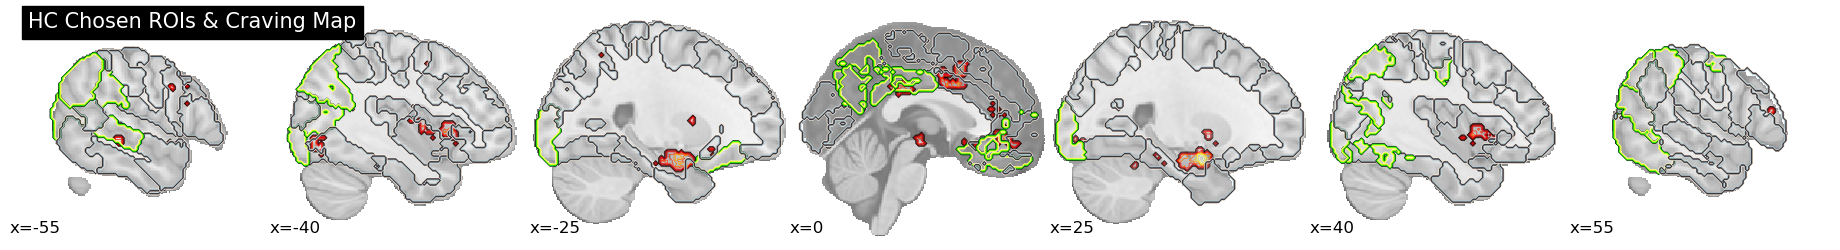

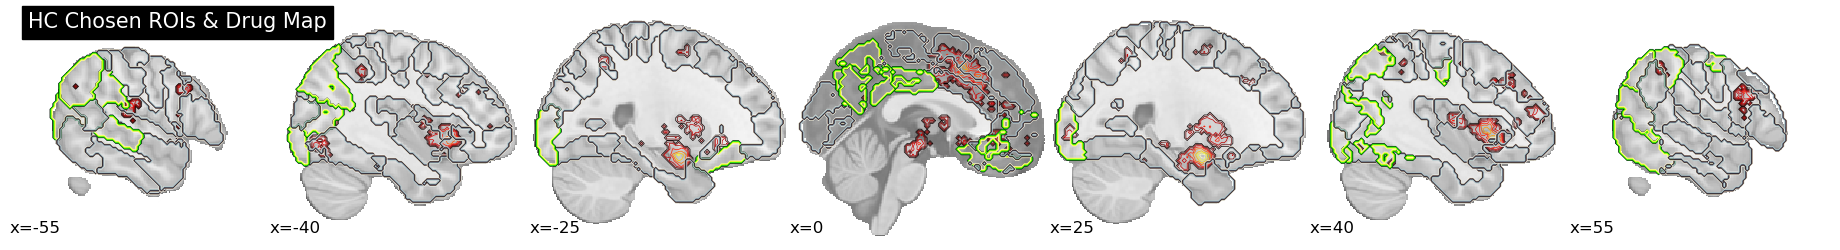

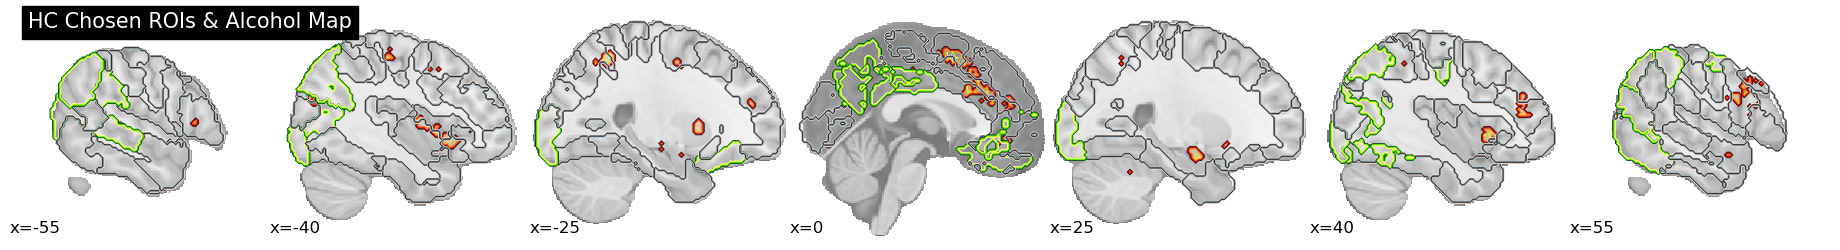

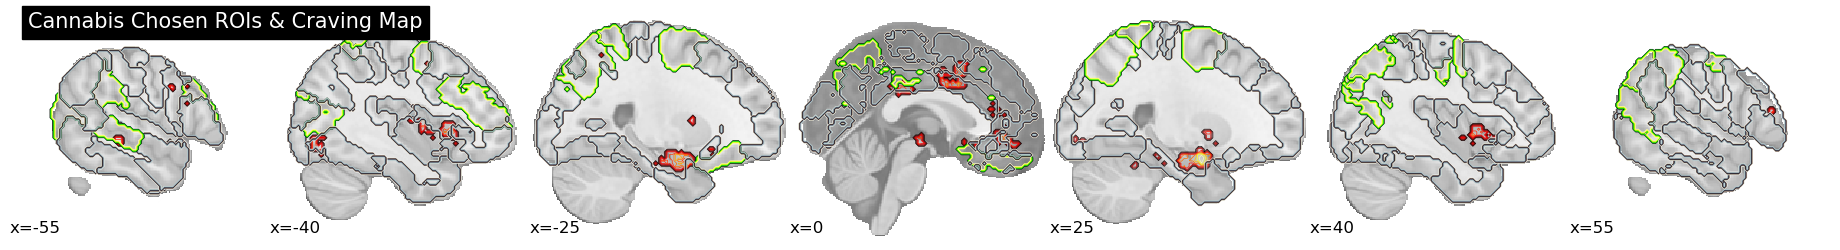

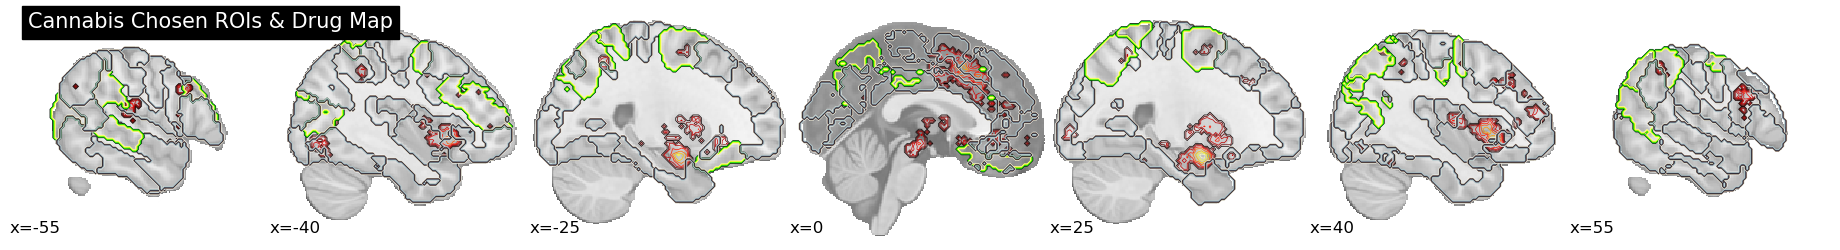

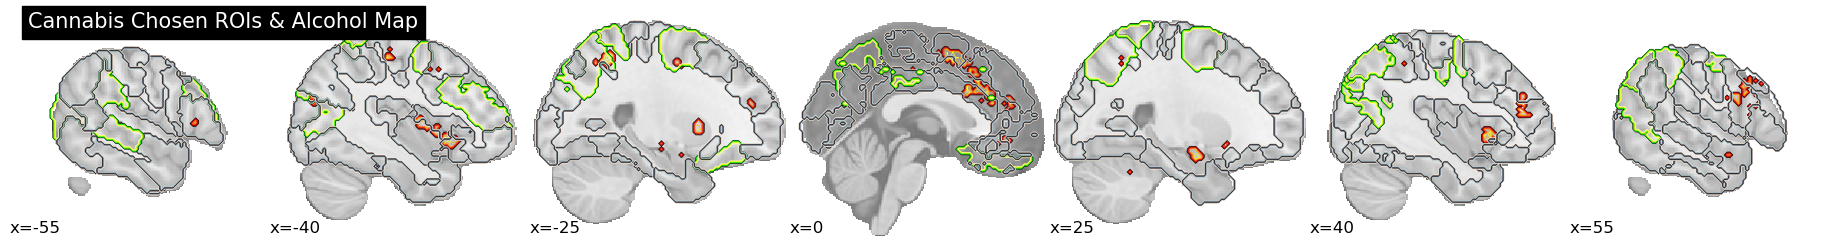

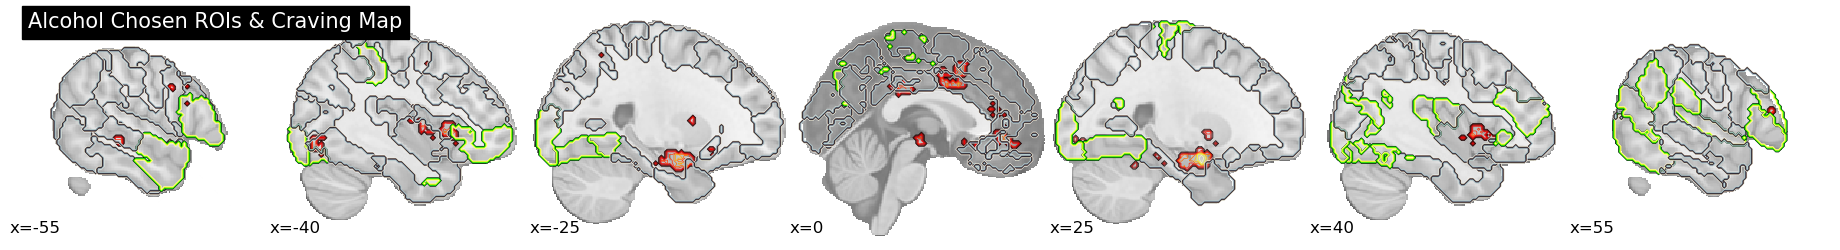

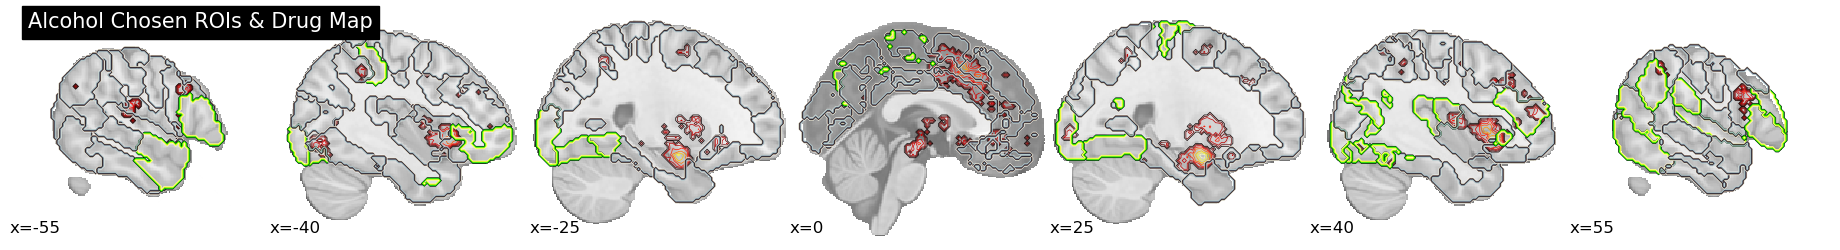

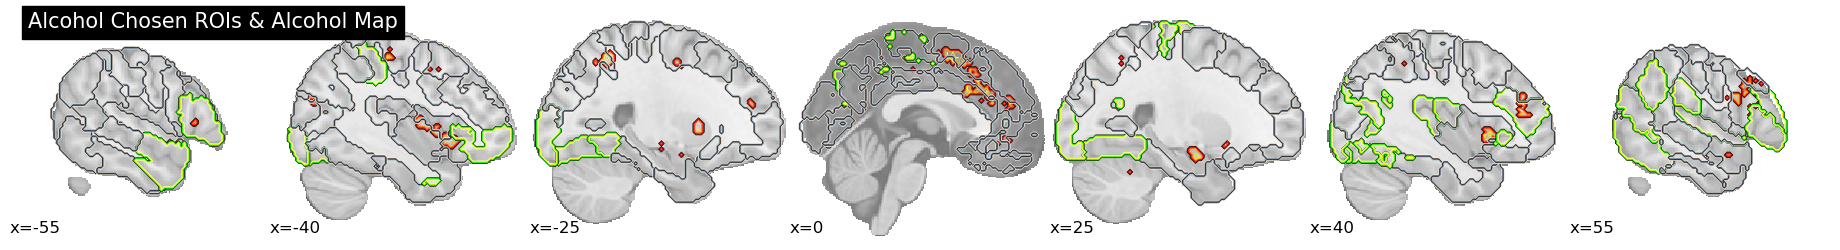

In [40]:
# === 4. Analyze and Plot Neurosynth Overlaps ===
# This cell iterates through the defined groups (HC, Cannabis, Alcohol) and
# Neurosynth maps (craving, drug, alcohol), generates overlap plots,
# and calculates quantitative overlap percentages.

print("\n" + "="*40)
print("Starting Neurosynth Overlap Analysis and Plotting")
print("="*40 + "\n")


# --- Analysis Loop ---
groups_to_analyze = list(CHOSEN_ROIS.keys()) # ['HC', 'Cannabis', 'Alcohol']
overlap_summary = {} # Store quantitative results

for group in groups_to_analyze:
    print(f"\n--- Processing Group: {group} ---")
    chosen_rois_for_group = CHOSEN_ROIS[group]
    overlap_summary[group] = {}

    if not chosen_rois_for_group:
        logging.warning(f"No chosen ROIs defined for group '{group}'. Skipping analysis.")
        continue

    for map_name, map_filename in NEUROSYNTH_MAPS.items():
        print(f"  Analyzing overlap with map: '{map_name}'")
        neurosynth_map_path = NEUROSYNTH_MAP_DIR / map_filename

        if not neurosynth_map_path.is_file():
             logging.warning(f"  Neurosynth map file not found: {neurosynth_map_path}. Skipping '{map_name}'.")
             overlap_summary[group][map_name] = {'error': 'Map file not found'}
             continue

        # --- Generate Plot ---
        plot_filename = f"{group.lower()}_rois_{map_name}_overlap.svg"
        plot_output_path = NEUROSYNTH_FIGURE_DIR / plot_filename
        plot_title = f"{group} Chosen ROIs & {map_name.capitalize()} Map"

        plot_roi_neurosynth_overlap(
            neurosynth_map_path=neurosynth_map_path,
            all_roi_images=roi_images,
            all_parcel_names=parcel_names,
            chosen_roi_names=chosen_rois_for_group,
            output_figure_path=plot_output_path,
            # bg_img='MNI152', # Default background
            display_mode=DISPLAY_MODE,
            cut_coords=CUT_COORDS,
            cmap_neurosynth=CONTOUR_CMAP_NEUROSYNTH,
            cmap_chosen=CONTOUR_CMAP_CHOSEN_ROI,
            cmap_other=CONTOUR_CMAP_OTHER_ROI,
            linewidth=CONTOUR_LINEWIDTH,
            title=plot_title
        )

        # --- Calculate Overlap ---
        overlap_list, non_overlap_list = calculate_roi_neurosynth_overlap(
            neurosynth_map_path=neurosynth_map_path,
            all_roi_images=roi_images,
            all_parcel_names=parcel_names,
            chosen_roi_names=chosen_rois_for_group
        )

        # Store and print results
        overlap_summary[group][map_name] = {
            'overlapping_rois': overlap_list,
            'non_overlapping_rois': non_overlap_list,
            'n_overlapping': len(overlap_list),
            'n_non_overlapping': len(non_overlap_list),
            'n_total_chosen': len(chosen_rois_for_group)
        }
        print(f"\n  Overlap Calculation Results ({group} / {map_name}):")
        print(f"    Overlapping ROIs ({len(overlap_list)}): {overlap_list}")
        print(f"    Non-Overlapping ROIs ({len(non_overlap_list)}): {non_overlap_list}")


# --- Optional: Save Summary ---
summary_path = ANALYSIS_RESULTS_DIR / "neurosynth_overlap_summary.pkl"
try:
    from src.file_utils import pickle_file # Ensure imported
    pickle_file(overlap_summary, summary_path)
    print(f"\nSaved overlap summary dictionary to: {summary_path}")
except Exception as e:
    print(f"\nFailed to save overlap summary: {e}")


print("\n" + "="*40)
print("Finished Neurosynth Overlap Analysis and Plotting")
print("="*40 + "\n")